In [1]:
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.Seq import Seq
from Bio.PDB import PDBParser
from collections import Counter
from itertools import product
import os
import pandas as pd
import numpy as np
from Bio.PDB import PDBParser
import matplotlib.pyplot as plt

In [2]:
def read_dca_scores(dca_path, L):
    
    pair_num = 0
    dca_scores = []  
    with open(dca_path) as f:
        for line in f:
            if line.startswith("#"):
                continue  
            i, j, score = map(float, line.split())
            if abs(int(i)-int(j)) > 4:
                dca_scores.append((int(i), int(j), score))
                pair_num += 1
            if pair_num == int(L/2):
                break
    dca_scores.sort(key=lambda x: x[2], reverse=True)
    
    return dca_scores

In [3]:
def max_freq_diff(i,j, stabilize, reference):

    pairs_stab = [(seq[i], seq[j]) for seq in stabilize]
    freqs_stab = {key: value / len(pairs_stab) for key, value in Counter(pairs_stab).items()}

    pairs_ref = [(seq[i], seq[j]) for seq in reference]
    freqs_ref = {key: value / len(pairs_ref) for key, value in Counter(pairs_ref).items()}
    
    AMINO_ACIDS = 'ACDEFGHIKLMNPQRSTVWY'
    max_diff = -100
    max_diff_pair = None
    for aa1, aa2 in product(AMINO_ACIDS, repeat=2):
        freq_stab_pair = freqs_stab.get((aa1, aa2), 0)
        freq_ref_pair = freqs_ref.get((aa1, aa2), 0)
        freq_diff =  (freq_stab_pair - freq_ref_pair)
        if freq_diff > max_diff:
            max_diff = freq_diff
            max_diff_pair = (aa1, aa2)
    
    return max_diff_pair, max_diff

In [4]:
def compare(dca_merg, dca_full, msa_cluster, msa_full):
    
    query = msa_full[0].seq
    results = []
    for i,j, score, clu_id in dca_merg:
        if (i,j) not in {(k, l) for k, l, _ in dca_full}:
            max_diff_pair, max_diff = max_freq_diff(i-1, j-1, msa_cluster, msa_full) 
            if query[i-1] != max_diff_pair[0] or query[j-1] != max_diff_pair[1]:
                results.append([i, j, (query[i-1], query[j-1]), clu_id, max_diff_pair, max_diff])
    df = pd.DataFrame(results, columns=['i','j','query','cluster id','pair','freq_diff'])
    return df

In [5]:
def find_contacts_single_chain(pdb_file):

    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)
    chain = structure[0].get_list()[0]

    ca_atoms = [(residue["CA"], residue.get_id()[1]) for residue in chain if "CA" in residue]

    contacts = []
    for i in range(len(ca_atoms)):
        for j in range(i + 1, len(ca_atoms)):  
            atom_A, index_A = ca_atoms[i]
            atom_B, index_B = ca_atoms[j]

            distance = np.linalg.norm(atom_A.coord - atom_B.coord)
            contacts.append((index_A, index_B, distance))

    return contacts

In [6]:
def plot_results(pdb_native, dca_full, pdb_alternative, df_sorted, ax, prot, p):

    i_nat, j_nat = zip(*pdb_native)
    di_nat, dj_nat = zip(*[(i, j) for i, j, _ in dca_full])

    i_alt, j_alt = zip(*pdb_alternative)
    di_alt, dj_alt = zip(*zip(df_sorted['i'], df_sorted['j']))
    
    if p == 1:
        labels = ['','Predicted Cα < 12 Å', 'DCA Alternative MSAs', 'DCA Full MSA']
    else:
        labels = ['','','','']
    
    ax.scatter(j_nat, i_nat, color='silver', label=labels[0], s=50)
    ax.scatter(i_alt, j_alt, color='silver', label=labels[1], s=50)

    ax.scatter(dj_nat, di_nat, color='red', label=labels[3], s=45) 
    ax.scatter(di_alt, dj_alt, color='orange', label=labels[2], s=45)

    x_tick_frequency = int(max(i_alt)/3)  
    y_tick_frequency = int(max(i_alt)/3)
    ax.xaxis.set_major_locator(plt.MultipleLocator(x_tick_frequency))
    ax.yaxis.set_major_locator(plt.MultipleLocator(y_tick_frequency))
    ax.tick_params(axis='x', labelsize=18) 
    ax.tick_params(axis='y', labelsize=18)
    
    min_val = 0  
    max_val = max(max(j_nat), max(i_nat), max(dj_nat), max(di_nat), max(i_alt), max(j_alt))  
    ax.plot([min_val, max_val], [min_val, max_val], '--', color='black')

    ax.text(0.06, 0.06, "Full MSA", horizontalalignment='left', verticalalignment='top', fontsize=20, transform=ax.transAxes) 
    ax.text(0.07, 0.07, "Alternative MSAs", horizontalalignment='right', verticalalignment='bottom', rotation=90, fontsize=20, transform=ax.transAxes)
    ax.set_title(prot, fontsize=22)

In [7]:
def main(prot):

    # threshold on Carbon alpha distances for contact definition
    threshold = 12.0
    # read full MSA 
    msa_full = AlignIO.read('../output_files/'+prot+'/sequence_files/full_MSA.fasta', "fasta")
    L = len(msa_full[0].seq)

    # read PDB of AF full MSA prediction
    pdb_nat = find_contacts_single_chain('../output_files/'+prot+'/results/fullMSA_noH.pdb')
    pdb_native = [(i, j) for i, j, k in pdb_nat if k <= threshold]

    # read in DCA output directory: here are stored the output couplings from the alternative and full MSAs 
    files = os.listdir('output_files/'+prot)
    # read the full MSA couplings which distinguish itself by tag "full"
    full_dca_path = 'output_files/'+ prot + '/' +[f for f in files if "full" in f][0]
    dca_full = read_dca_scores(full_dca_path, L)
    
    df = []
    pdbs_alternative = []
    clusters_dca = [f for f in files if "full" not in f]
    for i,c in enumerate(clusters_dca):
        
        name = c.replace('PLMDCA_apc_fn_scores_','').replace('.txt','')
        # read MSA associated to the alternative prediction
        msa_cluster = AlignIO.read('../output_files/'+prot+'/clusters/'+name+'.fasta', 'fasta')
        
        # read PDBs of AF alternative prediction and append it
        pdb_file = '../output_files/'+ prot + '/results/' + name.replace('ter_','') + '.pdb'
        pdb_cluster = find_contacts_single_chain(pdb_file)
        pdbs_alternative.append(pdb_cluster)

        # read top L/2 dca scores from clustered MSA associated with the alternative prediction 
        dca_clusters = read_dca_scores('output_files/'+prot+'/'+c, L)
        dca_merg = [t + (name,) for t in dca_clusters]

        # colculate top DCA scored pairs' frequencies 
        df.append(compare(dca_merg, dca_full, msa_cluster, msa_full))

    final_df = pd.concat(df, ignore_index=True)
    df_sorted = final_df.sort_values(by='freq_diff', ascending=False)

    # concat PDBs of alternative predictions and calculate average over distances
    pdb_list = [tup for sublist in pdbs_alternative for tup in sublist]
    pdb_df = pd.DataFrame(pdb_list, columns=['i', 'j', 'dist'])
    groups = pdb_df.groupby(['i','j'])['dist']
    pdb_alternative = [(i, j) for i, j in groups.groups if (groups.get_group((i,j)).sum()/len(clusters_dca) <= threshold)]
    
    return df_sorted, dca_full, pdb_native, pdb_alternative, L

KaiB
Mad2
RfaH
Proplasmepsin
ALPHA1-ANTITRYPSIN
CopK
MinE
Thioesterase_SP_1851


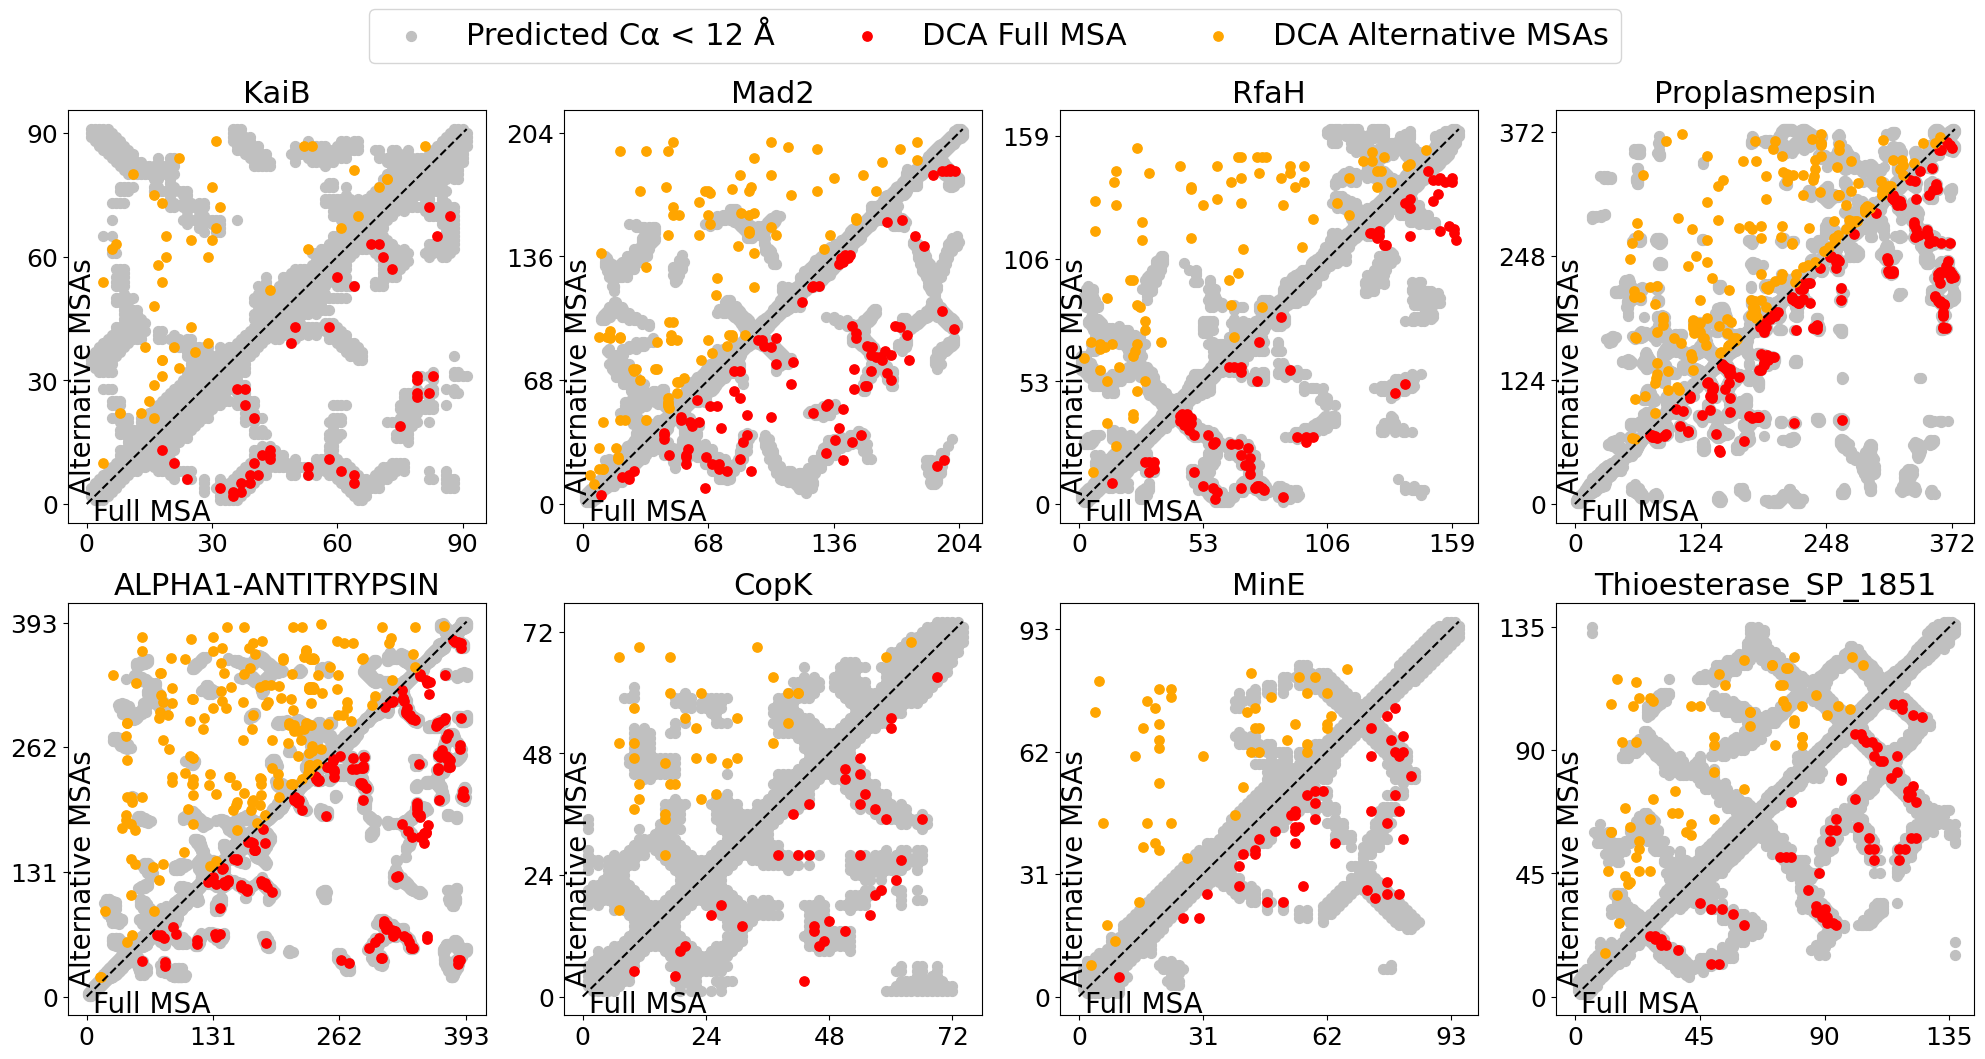

In [8]:
fig,axx = plt.subplots(2,4,figsize=(20,10))

files = ["KaiB", "Mad2", "RfaH", "Proplasmepsin", "ALPHA1-ANTITRYPSIN", "CopK",   "MinE", "Thioesterase_SP_1851"]

for p, prot in enumerate(files):
    print(prot)
    df_sorted, dca_full, pdb_native, pdb_alternative, L = main(prot)
    # plot results 
    if p < 4:
        ax = axx[0,p]
    else:
        ax = axx[1,p-4]
    plot_results(pdb_native, dca_full[:int(L/2)], pdb_alternative, df_sorted[:int(L/2)], ax, prot, p) 

    # save mutations of interesting pairs (contacts in alternative but not in full MSA prediction) 
    clean_list = []
    for index, row in df_sorted.iterrows():
        if (row['i'], row['j']) in pdb_alternative and (row['i'], row['j']) not in pdb_native:
            clean_list.append(row)
    df = df_sorted[:int(L/2)]
    clean_df = pd.DataFrame(clean_list, columns=df.columns)
    clean_df[['i','j','query','pair','cluster id','freq_diff']].to_csv('output_files/'+prot+'_muts.csv', index=False, quoting=3, escapechar=' ')
    
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.07), fontsize=22, ncol=4)
plt.tight_layout()
plt.show()

Kinase


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


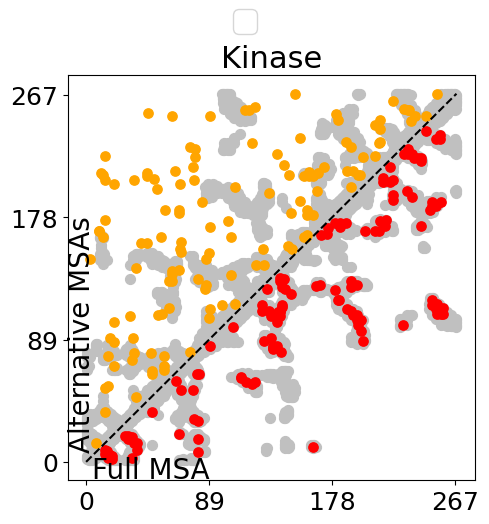

In [9]:
fig,ax = plt.subplots(1,1,figsize=(5,5))

files = ["Kinase"]

for p, prot in enumerate(files):
    print(prot)
    df_sorted, dca_full, pdb_native, pdb_alternative, L = main(prot)
    plot_results(pdb_native, dca_full[:int(L/2)], pdb_alternative, df_sorted[:int(L/2)], ax, prot, p) 

    clean_list = []
    for index, row in df_sorted.iterrows():
        if (row['i'], row['j']) in pdb_alternative and (row['i'], row['j']) not in pdb_native:
            clean_list.append(row)
    clean_df = pd.DataFrame(clean_list, columns=df_sorted.columns)
    clean_df[['i','j','query','pair','cluster id','freq_diff']].to_csv('output_files/'+prot+'_muts.csv', index=False, quoting=3, escapechar=' ')
    
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.07), fontsize=22, ncol=4)
plt.tight_layout()
plt.show()

Beta-1


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


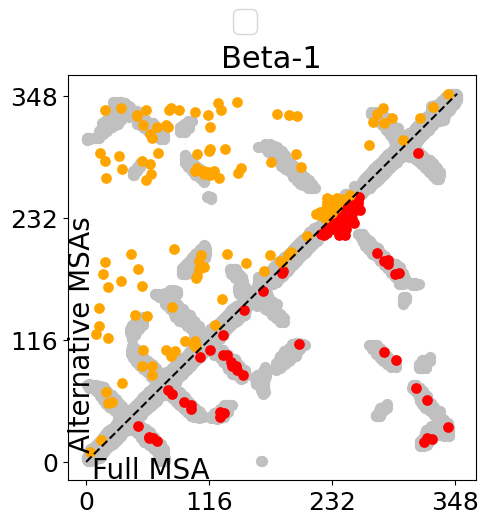

In [10]:
fig,ax = plt.subplots(1,1,figsize=(5,5))

files = ["Beta-1"]

for p, prot in enumerate(files):
    print(prot)
    df_sorted, dca_full, pdb_native, pdb_alternative, L = main(prot)
    plot_results(pdb_native, dca_full[:int(L/2)], pdb_alternative, df_sorted[:int(L/2)], ax, prot, p) 

    # save mutations of interesting pairs (contacts in alternative but not in full MSA prediction) 
    clean_list = []
    for index, row in df_sorted.iterrows():
      #  if (row['i'], row['j']) in pdb_alternative and (row['i'], row['j']) not in pdb_native:
        clean_list.append(row)
    clean_df = pd.DataFrame(clean_list, columns=df_sorted.columns)
    
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.07), fontsize=22, ncol=4)
plt.tight_layout()
plt.show()

lymphotactin


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


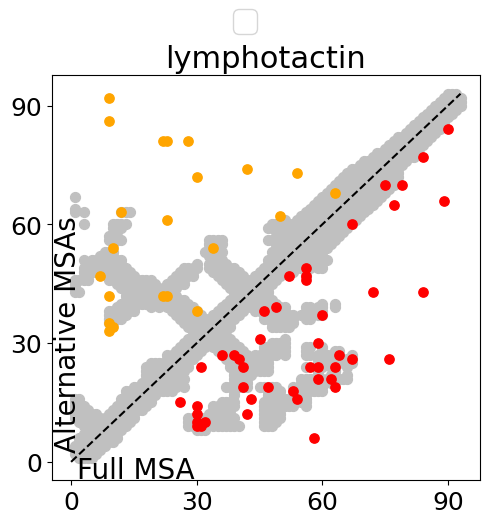

In [16]:
fig,ax = plt.subplots(1,1,figsize=(5,5))

files = ["lymphotactin"]

for p, prot in enumerate(files):
    print(prot)
    df_sorted, dca_full, pdb_native, pdb_alternative, L = main(prot)
    plot_results(pdb_native, dca_full, pdb_alternative, df_sorted, ax, prot, p) 

    clean_list = []
    for index, row in df_sorted.iterrows():
        if (row['i'], row['j']) not in pdb_native and (row['i'], row['j']) in pdb_alternative and (row['i'], row['j']):
            clean_list.append(row)
    clean_df = pd.DataFrame(clean_list, columns=df_sorted.columns)
  #  clean_df[['i','j','query','pair','cluster id','freq_diff']].to_csv('output_files/'+prot+'_muts.csv', index=False, quoting=3, escapechar=' ')
    
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.07), fontsize=22, ncol=4)
plt.tight_layout()
plt.show()

In [17]:
clean_df

,i,j,query,cluster id,pair,freq_diff
3,34,54,"(L, T)",cluster_2,"(M, D)",0.285468
14,12,63,"(V, M)",cluster_2,"(V, I)",0.236827
